In [27]:
import os
import sys
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

parent_path = os.path.dirname(os.getcwd())
tools_path = os.path.join(parent_path, 'tools')
sys.path.append(parent_path)
sys.path.append(tools_path)

from tools.path import get_env_path, get_prompt_from_file
from tools.agent_GEP import GeneticProgram
from tools.backtest import BacktestEngine
from tools.more_operators import *
from tools.evaluate_and_visualizations import *
from tools.common import update_database
from tools.multimodal import *

In [28]:
from dotenv import load_dotenv
env = get_env_path('project')
load_dotenv(env)

True

In [29]:
aapl = pd.read_feather(parent_path+'/data/AAPL_with_indicators.feather')
amzn = pd.read_feather(parent_path+'/data/AMZN_with_indicators.feather')
goog = pd.read_feather(parent_path+'/data/GOOGL_with_indicators.feather')
msft = pd.read_feather(parent_path+'/data/MSFT_with_indicators.feather')
tsla = pd.read_feather(parent_path+'/data/TSLA_with_indicators.feather')

In [30]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain.schema.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph

In [31]:
import operator
import base64
from typing import Annotated, Sequence, TypedDict, Optional, List

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from pandas import DataFrame

In [32]:
# Agent State在不同node里进行更新并且传输
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    time: str

    price_node_decision: str
    graph_node_decision: str
    news_node_decision: str
    final_decision: str
    
    # 存储当前训练的轮数
    roll: int

In [33]:
train_size = int(len(aapl) * 0.8)
test_df = aapl[train_size:]

date = test_df['date'].astype(str).to_list()
date[0]

'2023-02-22'

In [34]:
# 这里创建的是一个用来存储最终信号的空表格
none_list = [None]*len(date)
final_signal = pd.DataFrame({
    "date": date,
    "long signal": none_list,
    "short signal": none_list
})

price_base_path = parent_path + '/data/price/'
graph_base_path = parent_path + '/data/graph/'
news_base_path = parent_path + '/data/news/'

In [35]:
# 需要回测多少天
len(date)

299

In [36]:
def router(state):
    roll = state['roll']
    if roll == 299:
        # 认为已经找到了最好的signal
        return "__end__"
    return "continue"

In [37]:
def manager_node(state):
    
    # 控制轮数，每一轮代表每一天
    if state['roll'] == None:
        # 初始化
        state['roll'] = 0
    else:
        state['roll'] += 1
    
    when_is_now = state['roll']

    # TODO: 这里控制reflection

    return {
        "messages": ['Manager reflection made'],
        "time": date[when_is_now],
        "price_node_decision": None,
        "graph_node_decision": None,
        "news_node_decision": None,
        "final_decision": None,
        "roll": state['roll'],
    }

def price_node(state):
    # 这个agent需要提取的是价格特征
    # 第一个是短期价格特征-最近10天的
    # 第二个是长期价格特征-过去一个月的

    llm = ChatOpenAI(model="gpt-4-1106-preview")

    system_prompt = get_prompt_from_file("model_3_price_node")
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    time = state['time']
    short_term_price_path = price_base_path+time+'_short_term.feather'
    long_term_price_path = price_base_path+time+'_long_term.feather'

    short_term_price_changes = pd.read_feather(short_term_price_path)
    long_term_price_changes = pd.read_feather(long_term_price_path)

    prompt = prompt.partial(short_term_price_changes=short_term_price_changes)
    prompt = prompt.partial(long_term_price_changes=long_term_price_changes)
    signal_chain = prompt | llm
    
    result = signal_chain.invoke(['Please make an investment decision for me based on current price changes.'])
    price_node_decision = str(result.content)


    return {
        "messages": ['price_node decision made'],
        "time": state['time'],
        "price_node_decision": price_node_decision,
        "graph_node_decision": None,
        "news_node_decision": None,
        "final_decision": None,
        "roll": state['roll'],
    }

def graph_node(state):
    # 这个agent需要提取的是图片特征
    # 自动生成过去10天的K线图
    # 自动生成过去一个月的K线图 
    chain = ChatOpenAI(model="gpt-4o", max_tokens=1024)

    time = state['time']
    short_term_graph_path = graph_base_path+time+'_10days.png'
    long_term_graph_path = graph_base_path+time+'_1month.png'


    image1 = encode_image(short_term_graph_path)
    image2 = encode_image(long_term_graph_path)


    msg = chain.invoke(
        [   
            AIMessage(
            content="You are a AI investment assistant, responsible for assessing short-term and long-term k-line charts of stocks, and making decisions on whether to Invest."
            ),
            
            HumanMessage(
                content=[
                    {"type": "text", "text": "The k-line chart of the past 10 days is being displayed:"},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image1}"
                        },
                    },

                    {"type": "text", "text": "The k-line chart of the past month is being displayed:"},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image2}"
                        },
                    },
                    {"type": "text", "text": "Please clarify explicitly whether I should buy, sell, or wait. Your response should be limited to only 'LONG', 'SHORT', or 'WAIT'."},
                    {"type": "text", "text": "You don't need to explain the reason, only output and respond one word with 'LONG', 'SHORT', or 'WAIT'."},
                    {"type": "text", "text": "You should pay attention to the structure of the K-line and the dynamic changes in volumes."},
                    {"type": "text", "text": "Please note that you should prefer to select 'LONG' or 'SHORT' instead of 'WAIT'."},
                ]
            )
        ]
    )

    graph_node_decision = str(msg.content)



    return {
        "messages": ['graph_node decision made'],
        "time": state['time'],
        "price_node_decision": state['price_node_decision'],
        "graph_node_decision": graph_node_decision,
        "news_node_decision": None,
        "final_decision": None,
        "roll": state['roll'],
    }

def news_node(state):
    # 给出目标标的当天发生的新闻
    time = state['time']

    news_path = news_base_path+time+'.feather'
    news = pd.read_feather(news_path)
    news_combined = news['News'].str.cat(sep=' ')

    llm = ChatOpenAI(model="gpt-4-1106-preview")
    
    system_prompt = get_prompt_from_file("model_3_news_node")
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    
    prompt = prompt.partial(news_combined=news_combined)
    signal_chain = prompt | llm

    result = signal_chain.invoke(['Please make an investment decision for me based on news events today.'])
    news_node_decision = str(result.content)

    
    return {
        "messages": ['news_node decision made'],
        "time": state['time'],
        "price_node_decision": state['price_node_decision'],
        "graph_node_decision": state['graph_node_decision'],
        "news_node_decision": news_node_decision,
        "final_decision": None,
        "roll": state['roll'],
    }

def evaluate_node(state):
        
    when_is_now = state['roll']

    # 总结每一个节点的决策
    llm = ChatOpenAI(model="gpt-4-1106-preview")

    system_prompt = get_prompt_from_file("model_3_evaluate_node")
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    
    prompt = prompt.partial(price_node_decision=state['price_node_decision'])
    prompt = prompt.partial(graph_node_decision=state['graph_node_decision'])
    prompt = prompt.partial(news_node_decision=state['news_node_decision'])
    signal_chain = prompt | llm
    
    result = signal_chain.invoke(['Help me make the investment decision at the current time point.'])
    final_decision = str(result.content)

    if result.content == "LONG":
        final_signal.loc[when_is_now, 'long signal'] = 1

    elif result.content == "SHORT":
        final_signal.loc[when_is_now,'short signal'] = -1

    # 初始化
    return {
        "messages": ['Evaluate was made'],
        "time": state['time'],
        "price_node_decision": state['price_node_decision'],
        "graph_node_decision": state['graph_node_decision'],
        "news_node_decision": state['news_node_decision'],
        "final_decision": final_decision,
        "roll": state['roll'],
    }

In [38]:
workflow = StateGraph(AgentState)

workflow.add_node("manager", manager_node)
workflow.add_node("price_node", price_node)
workflow.add_node("graph_node", graph_node)
workflow.add_node("news_node", news_node)
workflow.add_node("evaluate", evaluate_node)


workflow.add_edge("manager", "price_node")
workflow.add_edge("price_node", "graph_node")
workflow.add_edge("graph_node", "news_node")
workflow.add_edge("news_node", "evaluate")
#workflow.add_edge("evaluate", END)

workflow.add_conditional_edges(
    "evaluate",
    router,
    {"continue": "manager", "__end__": END},
)

workflow.set_entry_point("manager")
graph = workflow.compile()

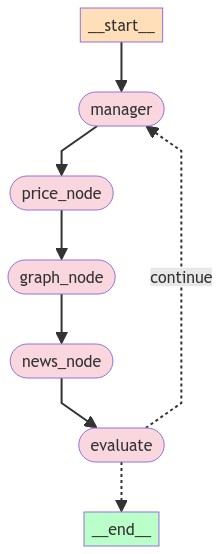

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [40]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Lets start !"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'manager': {'messages': ['Manager reflection made'], 'time': '2023-02-22', 'price_node_decision': None, 'graph_node_decision': None, 'news_node_decision': None, 'final_decision': None, 'roll': 0}}
----
{'price_node': {'messages': ['price_node decision made'], 'time': '2023-02-22', 'price_node_decision': 'WAIT', 'graph_node_decision': None, 'news_node_decision': None, 'final_decision': None, 'roll': 0}}
----
{'graph_node': {'messages': ['graph_node decision made'], 'time': '2023-02-22', 'price_node_decision': 'WAIT', 'graph_node_decision': 'SHORT', 'news_node_decision': None, 'final_decision': None, 'roll': 0}}
----
{'news_node': {'messages': ['news_node decision made'], 'time': '2023-02-22', 'price_node_decision': 'WAIT', 'graph_node_decision': 'SHORT', 'news_node_decision': 'WAIT', 'final_decision': None, 'roll': 0}}
----
{'evaluate': {'messages': ['Evaluate was made'], 'time': '2023-02-22', 'price_node_decision': 'WAIT', 'graph_node_decision': 'SHORT', 'news_node_decision': 'WAIT', 

KeyboardInterrupt: 